In [6]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

In [2]:
datadir = os.path.join('..', 'data', 'modeling', 'predict')
adata = sc.read_h5ad(os.path.join(datadir, 'training.h5ad'))
adata

AnnData object with n_obs × n_vars = 1575028 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 'training', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score'

In [3]:
u_from_z = lambda z: np.log(np.expm1(np.expm1(z) - 1e-6))
log1p_u_min = -3

adata.obs['latent_u'] = u_from_z(adata.obs.latent_z)
adata.obs['log1p_u'] = np.log1p(adata.obs.latent_u)
adata.obs.log1p_u.clip(lower = log1p_u_min, inplace = True)

/home/caleb/miniconda3/envs/scanpy/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_384462/3712767899.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs.log1p_u.clip(lower = log1p_u_min, inplace = True)


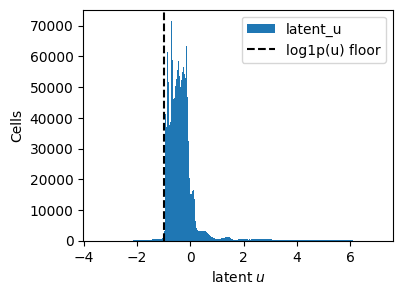

In [4]:
plt.figure(figsize = (4, 3))
adata.obs.latent_u.plot.hist(bins = 300, ax = plt.gca())
plt.axvline(-1, c = 'k', ls = '--', label = 'log1p(u) floor')
plt.xlabel(r'latent $u$')
plt.ylabel('Cells')
plt.legend()
plt.show()

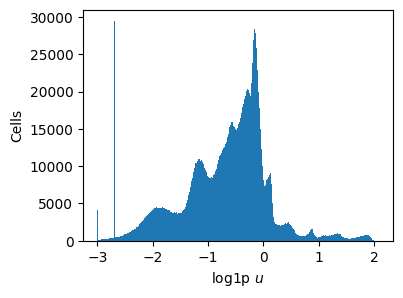

In [5]:
plt.figure(figsize = (4, 3))
adata.obs.log1p_u.plot.hist(bins = 300, ax = plt.gca())
plt.xlabel(r'log1p $u$')
plt.ylabel('Cells')
plt.show()

In [ ]:
# per-category histograms
nbins = 30
log1p_u_bin = pd.cut(adata.obs.log1p_u, bins = nbins)
df = pd.crosstab(adata.obs.category, log1p_u_bin, normalize = 0)
ix = adata.obs.groupby('category').latent_z.median().sort_values().index
df = df.loc[ix]

/tmp/ipykernel_384462/78805736.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ix = adata.obs.groupby('category').latent_z.median().sort_values().index


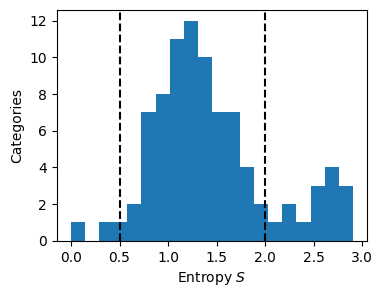

['Sympathetic Neuron' 'Chromaffin Cell' 'Enteric Neuron' 'Chondrocyte'
 'Sensory Neuron' 'Small Cell Lung Cancer'
 'Pancreatic Ductal Adenocarcinoma' 'CNS Neurons' 'Metastatic Melanoma'
 'Ovarian Cancer' 'Breast Cancer' 'Joint Progenitor' 'Skeletal Progenitor'
 'Renal Cell Carcinoma' 'Glioblastoma' 'Posterior Epiblast']


In [ ]:
# filter noisy categories
Slim = [.5, 2]
S = entropy(df, axis = 1)
S_msk = (S > Slim[0]) & (S < Slim[1])
plt.figure(figsize = (4, 3))
plt.hist(S, bins = 20)
plt.axvline(Slim[0], c = 'k', ls = '--')
plt.axvline(Slim[1], c = 'k', ls = '--')
plt.xlabel(r'Entropy $S$')
plt.ylabel('Categories')
plt.show()

print(df.index[~S_msk].values.to_numpy())

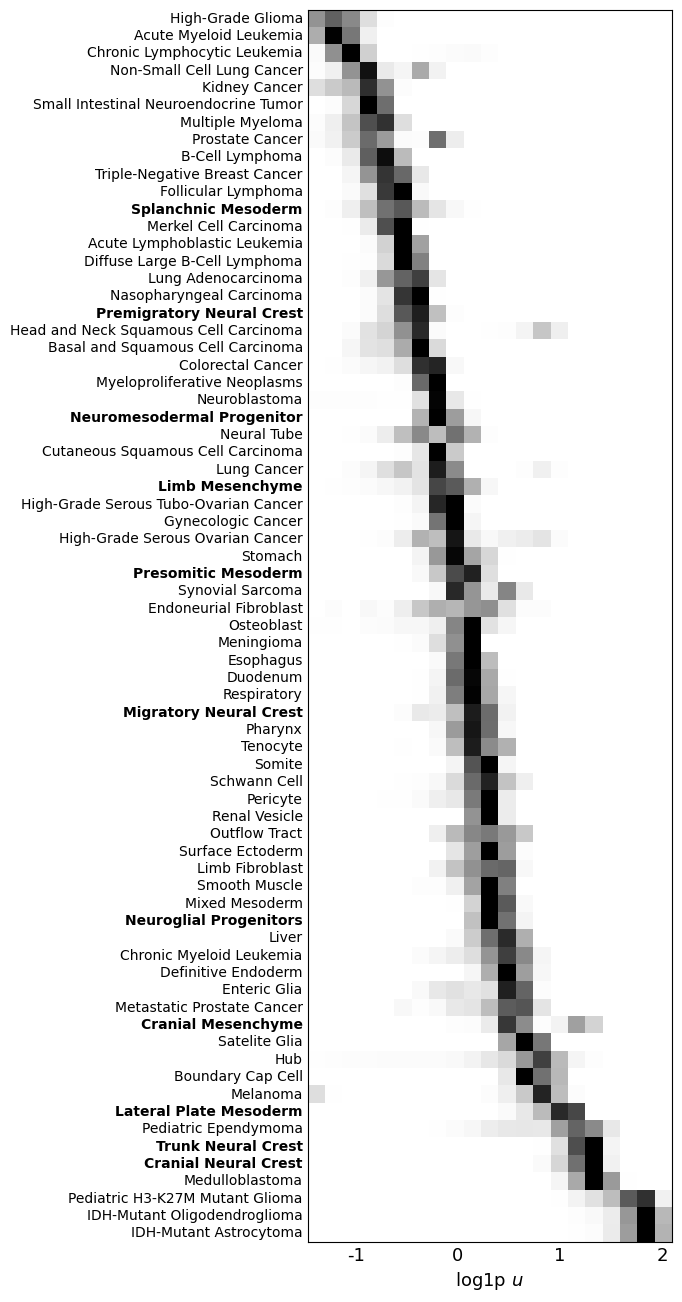

In [ ]:
left, xticklim, xtickstep, fs = -1.5, [-1, 2], 1, 13
xticklabels = np.arange(xticklim[0], xticklim[1] + 1e-3, xtickstep)
xticklabels = xticklabels.astype(int)
msk_plt = np.asarray([cat.left >= left for cat in log1p_u_bin.cat.categories])
df_plt = df.iloc[S_msk, msk_plt]
left_bin_plt = log1p_u_bin.cat.categories[msk_plt][0]
xticks = (xticklabels - left_bin_plt.left) / left_bin_plt.length
vmax = np.quantile(df_plt.values[df_plt > 0], .95)

fig, ax = plt.subplots(1, 1, figsize = (6, 16))
sns.heatmap(df_plt,
            cmap = 'binary',
            vmax = vmax,
            square = True,
            cbar = False,
            ax = ax)
ax.set_xticks(xticks, xticklabels, rotation = 0, fontsize = fs)
ax.tick_params('both', size = 0)
ax.set_xlabel(r'log1p $u$', fontsize = fs)
ax.set_ylabel('')

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('k')

msk_traj = (adata.obs.trajectory == 'True')
celltype_traj = adata[msk_traj].obs.celltype.cat.categories
for label in ax.get_yticklabels():
    if label.get_text() in celltype_traj:
        label.set_fontweight('bold')

plt.show()